### Importing libraries

In [1]:
#!pip install dtreeviz
#!brew install libomp
# pip install azure-cognitiveservices-search-imagesearch

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from typing import List
from torch.optim import Adam
import torch.nn.functional as F

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from utils import *

import seaborn as sns
from dtreeviz.trees import *

### loading and understanding dataset

In [2]:
df = pd.read_csv('districts_without_ID.csv', low_memory=False)
df.drop(columns = ['Unnamed: 0', 'Short-wave irradiation'], inplace=True)
df.columns

Index(['st_area(sh', 'st_length(', 'Confirmed', 'Active', 'Recovered',
       'Deceased', 'Zone', 'Population', 'Temperature', 'Relative Humidity',
       'Pressure', 'Wind speed', 'Wind direction', 'Rainfall', 'Snowfall',
       'Snow Depth'],
      dtype='object')

In [3]:
df.head()

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Zone,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth
0,1.353967e+10,8.464308e+05,50098,5387,43426,1285,0,3679936.0,308.37,23.87,966.23,4.70,315.61,0.001023,0.0,0.0
1,1.771358e+10,9.720056e+05,82865,13676,67784,1405,0,4993796.0,304.67,39.49,946.62,3.85,299.27,0.016242,0.0,0.0
2,1.294532e+10,7.410244e+05,11822,3574,8091,157,1,2071101.0,309.31,23.72,979.54,0.56,279.09,0.000001,0.0,0.0
3,1.547940e+10,1.014942e+06,9472,1510,7702,260,0,2077144.0,309.29,20.82,969.33,1.24,300.10,0.000001,0.0,0.0
4,1.186387e+10,1.131732e+06,17148,4312,12390,446,1,2876259.0,308.89,22.19,961.30,0.42,358.68,0.000028,0.0,0.0


In [4]:
df.dtypes

# df_p = df.Population.astype(np.float64)
# df.dtypes

st_area(sh           float64
st_length(           float64
Confirmed              int64
Active                 int64
Recovered              int64
Deceased               int64
Zone                   int64
Population            object
Temperature          float64
Relative Humidity    float64
Pressure             float64
Wind speed           float64
Wind direction       float64
Rainfall             float64
Snowfall             float64
Snow Depth           float64
dtype: object

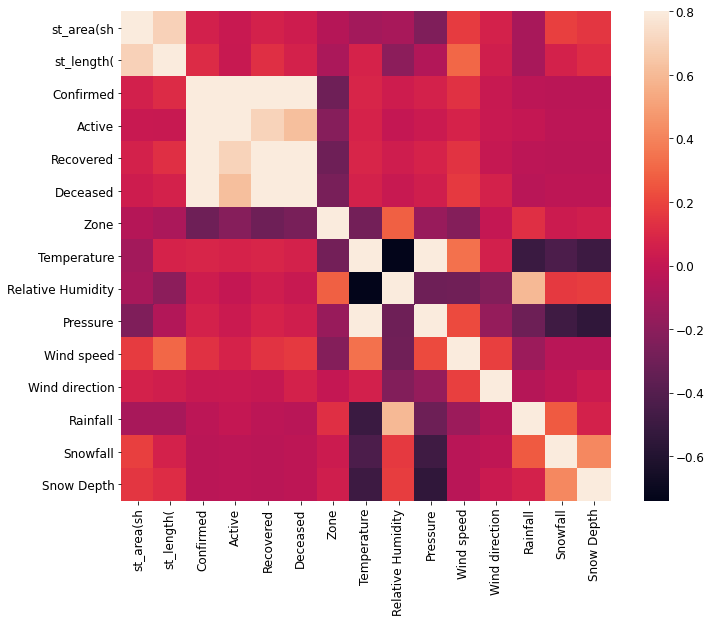

In [5]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

### Pre-processing

In [6]:
def convert_str_to_float(s):
    s_new = s.replace(',', '')
    return float(s_new)

In [7]:
df['Population'] = df['Population'].apply(convert_str_to_float)
df.head()

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Zone,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth
0,1.353967e+10,8.464308e+05,50098,5387,43426,1285,0,3679936.0,308.37,23.87,966.23,4.70,315.61,0.001023,0.0,0.0
1,1.771358e+10,9.720056e+05,82865,13676,67784,1405,0,4993796.0,304.67,39.49,946.62,3.85,299.27,0.016242,0.0,0.0
2,1.294532e+10,7.410244e+05,11822,3574,8091,157,1,2071101.0,309.31,23.72,979.54,0.56,279.09,0.000001,0.0,0.0
3,1.547940e+10,1.014942e+06,9472,1510,7702,260,0,2077144.0,309.29,20.82,969.33,1.24,300.10,0.000001,0.0,0.0
4,1.186387e+10,1.131732e+06,17148,4312,12390,446,1,2876259.0,308.89,22.19,961.30,0.42,358.68,0.000028,0.0,0.0


In [8]:
df.dtypes

st_area(sh           float64
st_length(           float64
Confirmed              int64
Active                 int64
Recovered              int64
Deceased               int64
Zone                   int64
Population           float64
Temperature          float64
Relative Humidity    float64
Pressure             float64
Wind speed           float64
Wind direction       float64
Rainfall             float64
Snowfall             float64
Snow Depth           float64
dtype: object

In [9]:
ss = StandardScaler()
for col in df.columns:
    if(col != 'Zone'):
        df[col] = ss.fit_transform(df[col].values.reshape(-1, 1))

In [10]:
df.head()

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Zone,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth
0,0.833805,1.034626,1.808586,0.819825,1.930220,2.178445,0,1.317417,1.010754,-1.367494,0.142530,2.526869,0.971593,-0.532420,-0.105543,-0.104627
1,1.265520,1.449667,3.246962,2.575720,3.229629,2.405952,0,2.195896,0.371724,-0.501618,-0.176366,1.831552,0.794999,-0.524425,-0.105543,-0.104627
2,0.772331,0.686244,0.128381,0.435769,0.045229,0.039883,1,0.241710,1.173102,-1.375809,0.358977,-0.859733,0.576905,-0.532957,-0.105543,-0.104627
3,1.034435,1.591577,0.025223,-0.001457,0.024478,0.235159,0,0.245750,1.169648,-1.536567,0.192942,-0.303480,0.803969,-0.532957,-0.105543,-0.104627
4,0.660475,1.977584,0.362177,0.592103,0.274565,0.587795,1,0.780058,1.100564,-1.460622,0.062359,-0.974256,1.437069,-0.532943,-0.105543,-0.104627


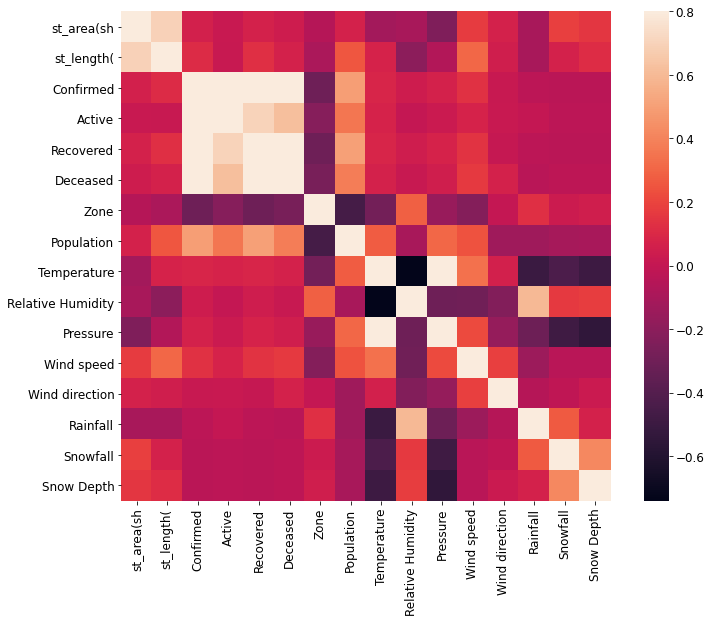

In [11]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [12]:
split = ( list(range(80*len(df) // 100)), list(set(range(len(df))) - set(range(80*len(df) // 100))) )
cont_var = [i for i in df.columns if i!='Zone']

In [13]:
to = TabularPandas(df, cont_names=cont_var, y_names='Zone', splits=split)

In [14]:
to.train.xs

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth
0,0.833805,1.034626,1.808586,0.819825,1.930220,2.178445,1.317417,1.010754,-1.367494,0.142530,2.526869,0.971593,-0.532420,-0.105543,-0.104627
1,1.265520,1.449667,3.246962,2.575720,3.229629,2.405952,2.195896,0.371724,-0.501618,-0.176366,1.831552,0.794999,-0.524425,-0.105543,-0.104627
2,0.772331,0.686244,0.128381,0.435769,0.045229,0.039883,0.241710,1.173102,-1.375809,0.358977,-0.859733,0.576905,-0.532957,-0.105543,-0.104627
3,1.034435,1.591577,0.025223,-0.001457,0.024478,0.235159,0.245750,1.169648,-1.536567,0.192942,-0.303480,0.803969,-0.532957,-0.105543,-0.104627
4,0.660475,1.977584,0.362177,0.592103,0.274565,0.587794,0.780058,1.100564,-1.460622,0.062359,-0.974256,1.437069,-0.532943,-0.105543,-0.104627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.076504,-0.207923,-0.304664,-0.146352,-0.327021,-0.223646,-0.824256,-1.935691,0.837663,-2.224558,-0.859733,1.137271,0.605258,-0.105543,-0.104418
568,-0.490434,-1.114948,-0.299308,-0.289340,-0.285251,-0.197104,-0.965252,-2.636897,1.001192,-3.071317,-1.096959,0.532162,1.284775,-0.105543,-0.103793
569,-0.390870,-0.638833,-0.288861,-0.303109,-0.269674,-0.176249,-0.860131,-2.569540,0.934118,-3.028060,-0.957895,0.861789,1.081636,-0.105543,-0.104140
570,-0.167908,-0.528054,-0.262347,-0.209690,-0.260765,-0.183832,-0.729023,-1.348475,0.623134,-1.558794,-0.393462,1.201143,0.143193,-0.105543,-0.104627


In [15]:
train_xs, train_y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

### Decision Trees

In [16]:
DT = DecisionTreeClassifier()
DT.fit(train_xs, train_y)

DecisionTreeClassifier()

In [17]:
DT.get_n_leaves(), DT.get_depth()

(133, 19)

In [18]:
to.show(4)

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth,Zone
0,0.833805,1.034626,1.808586,0.819825,1.930220,2.178445,1.317417,1.010754,-1.367494,0.142530,2.526869,0.971593,-0.532420,-0.105543,-0.104627,0
1,1.265520,1.449667,3.246962,2.575720,3.229629,2.405952,2.195896,0.371724,-0.501618,-0.176366,1.831552,0.794999,-0.524425,-0.105543,-0.104627,0
2,0.772331,0.686244,0.128381,0.435769,0.045229,0.039883,0.241710,1.173102,-1.375809,0.358977,-0.859733,0.576905,-0.532957,-0.105543,-0.104627,1
3,1.034435,1.591577,0.025223,-0.001457,0.024478,0.235159,0.245750,1.169648,-1.536567,0.192942,-0.303480,0.803969,-0.532957,-0.105543,-0.104627,0


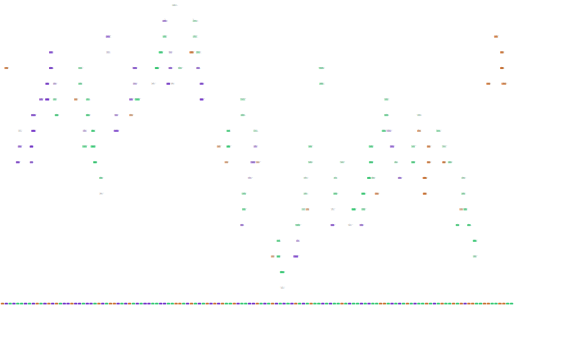

In [19]:
draw_tree(DT, train_xs, size=8, leaves_parallel=True, precision=2)

In [20]:
# samp_idx = np.random.permutation(len(train_y))[:500]
# dtreeviz(DT, train_xs.iloc[samp_idx], train_y.iloc[samp_idx], train_xs.columns, cont_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

In [21]:
def rmse(pred, y): return round(np.abs(pred-y).mean(), 6)
def model_rmse(model, xs, y): return rmse(model.predict(xs), y)

In [22]:
model_rmse(DT, train_xs, train_y)

0.0

In [23]:
model_rmse(DT, valid_xs, valid_y)

0.356643

In [24]:
DT.get_n_leaves(), len(train_xs)

(133, 572)

In [25]:
minm_config = dict()
min_loss = 1.0
for msf in range(1, 30):
    DT = DecisionTreeClassifier(min_samples_leaf=msf) 
    DT.fit(train_xs, train_y)
    valid_loss = model_rmse(DT, valid_xs, valid_y)
    if valid_loss < min_loss:
        min_loss = valid_loss
        minm_config['min_sample_leaf'] = msf
        minm_config['validation_rmse'] = valid_loss
        
minm_config

{'min_sample_leaf': 14, 'validation_rmse': 0.27972}

In [26]:
DT.get_n_leaves()

15

### Random Forest

In [27]:
def rf(xs, y, n_estimators=40, max_samples=570,
       max_features=0.5, min_samples_leaf=10, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [28]:
RF = rf(train_xs, train_y)

In [29]:
model_rmse(RF, train_xs, train_y), model_rmse(RF, valid_xs, valid_y)

(0.222028, 0.237762)

### Using Fastai and Pytorch

In [30]:
# to create a custom dataset, we need to specify __len__ and __getit

class DistrictDataset(Dataset):
    
    def __init__(self, DataFrame, dep_var, idep_var, transform=None,):
        self.transform = transform 
        self.df = DataFrame
        self.transform = transform
        self.dep_var = dep_var
        self.idep_var = idep_var
        
    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, idx):
        if(isinstance(idx, np.ndarray)):
            idx = idx.tolist()   
        elif(torch.is_tensor(idx)):
            idx = idx.tolist()
            
        x = df[self.idep_var].iloc[idx]
        target = df[self.dep_var].iloc[idx]
        
        sample = {'features': np.array(x, dtype=np.float32),
                'targets': np.array(target, dtype=np.int).squeeze()} 
        
        if self.transform:
            sample = self.transform(sample)

        return (sample['features'], sample['targets'])

In [31]:
df_train = df.iloc[split[0]]
df_valid = df.iloc[split[1]]

In [32]:
class ToTensor(object):
    
    def __call__(self, sample):
        return {'features': torch.from_numpy(sample['features']),
                 'targets': torch.from_numpy(sample['targets'])}

In [33]:
df.to_numpy()

array([[ 0.83380536,  1.03462586,  1.80858624, ..., -0.53242003, -0.10554271, -0.10462703],
       [ 1.26552045,  1.44966696,  3.24696227, ..., -0.52442531, -0.10554271, -0.10462703],
       [ 0.77233096,  0.68624399,  0.12838113, ..., -0.5329569 , -0.10554271, -0.10462703],
       ...,
       [-0.21057194, -0.85512794, -0.38942897, ...,  1.03323516, -0.0103256 , -0.07782284],
       [-0.38564949, -0.97998908, -0.36247616, ...,  0.34993765, -0.10554271, -0.10375789],
       [-0.39364631, -0.9167401 , -0.38991184, ...,  0.71901137, -0.10554271, -0.10459226]])

In [34]:
train_dist = DistrictDataset(df_train, dep_var=['Zone'], idep_var=cont_var, transform=ToTensor())
valid_dist = DistrictDataset(df_valid, dep_var=['Zone'], idep_var=cont_var, transform=ToTensor())

In [35]:
train_dist.__getitem__(0)

(tensor([ 0.8338,  1.0346,  1.8086,  0.8198,  1.9302,  2.1784,  1.3174,  1.0108, -1.3675,  0.1425,  2.5269,  0.9716, -0.5324, -0.1055, -0.1046]),
 tensor(0))

In [36]:
dls = DataLoaders.from_dsets(train_dist, valid_dist)

## For pytorch Pipeline

In [38]:
class Model_pt(nn.Module):
    
    def __init__(self, num_cols, output_size, n_layers: List[int], p=0.4):
        super().__init__()
#         self.batch_norm_num = nn.BatchNorm1d(num_cols)
        
        in_size = num_cols
        all_layers = []
        for i in n_layers:
            all_layers.append(nn.Linear(in_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            in_size = i
            
        all_layers.append(nn.Linear(n_layers[-1], output_size))
#         all_layers.append(nn.Softmax(dim=1))
        
        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_numerical):
#         x_numerical = self.batch_norm_num(x_numerical)
        x = self.layers(x_numerical)
        return x

In [39]:
epochs = 5
aggregates_losses = []

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

for i in range(epochs):
    # loading Datalaoder for our model
    for sample in train_dl:
        sample['features'], sample['targets'] = sample['features'].to(device), sample['targets'].to(device)
    pred_mat = model(sample['features'].float())
    y_pred = torch.argmax(pred_mat, dim=1)
    targets = torch.squeeze(sample['targets'])
    single_loss = loss_func(y_pred, targets)
    aggregated_losses.append(single_loss)
    
    print(f"epoch: {i+1} ; loss: {single_loss.item()}")
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

NameError: name 'train_dl' is not defined

## For fastai pipeline

In [40]:
class Model_fa(nn.Module):
# num_cols, 64, 128, 63, 32, 10, OP_size    
    def __init__(self, num_cols, output_size, n_layers: List[int], p=0.4):
        super().__init__()
#         self.batch_norm_num = nn.BatchNorm1d(num_cols)
        
        self.linear1 = nn.Linear(15, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 32)
        self.linear5 = nn.Linear(32, 10)
        self.linear6 = nn.Linear(10, 3)
        self.relu = nn.ReLU(inplace=True)
#         self.bn1 = nn.BatchNorm1d(16)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(32)
        self.bn5 = nn.BatchNorm1d(10)
        self.bn6 = nn.BatchNorm1d(3)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.dropout(self.bn1(self.relu(self.linear1(x))))
        x = self.dropout(self.bn2(self.relu(self.linear2(x))))
        x = self.dropout(self.bn3(self.relu(self.linear3(x))))
        x = self.dropout(self.bn4(self.relu(self.linear4(x))))
        x = self.dropout(self.bn5(self.relu(self.linear5(x))))
        x = self.dropout(self.bn6(self.relu(self.linear6(x))))
        return x

In [41]:
model = Model_fa(num_cols = len(to.train.xs.columns), output_size = 3, n_layers=[64, 128, 63, 32, 10], p=0.4)

print(model)

Model_fa(
  (linear1): Linear(in_features=15, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
  (linear6): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU(inplace=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)

In [42]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [44]:
learner = Learner(dls, model, loss_func=loss_func, metrics=[accuracy])

In [48]:
learner.freeze()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=3.311311274956097e-06)

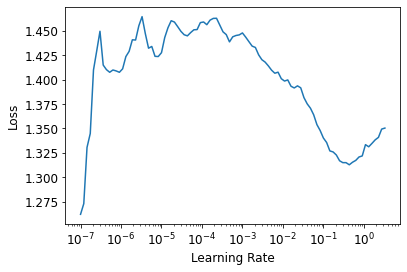

In [49]:
learner.lr_find()

In [52]:
learner.fit_one_cycle(100, 2e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.301544,0.989739,0.573427,00:00
1,1.344658,1.000102,0.559441,00:00
2,1.302834,1.002297,0.559441,00:00
3,1.288761,0.996468,0.552448,00:00
4,1.295240,1.001027,0.573427,00:00
5,1.292718,0.993438,0.580420,00:00
6,1.275278,0.999200,0.566434,00:00
7,1.273326,1.007529,0.559441,00:00
8,1.264641,1.007271,0.552448,00:00
9,1.264667,0.998960,0.566434,00:00


In [56]:
learner.save('../models/hot-model')

Path('models/../models/hot-model.pth')